In [ ]:
# AQUI CARGAMOS LAS LIBRERÍAS NECESARIAS A UTILIZAR
import numpy as np

%matplotlib inline
from keras.utils import plot_model
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from keras import layers
from keras.models import Model
from keras.models import load_model
import pandas as pd
import cv2
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# AQUI DESCARGAMOS EL COMPRIMIDO DEL DATASET
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1EcTWqMW8tLYQ32_MXg2m_xrWo1w0AqXf' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1EcTWqMW8tLYQ32_MXg2m_xrWo1w0AqXf" -O "Data.zip" && rm -rf /tmp/cookies.txt

--2025-05-24 17:11:21--  https://docs.google.com/uc?export=download&confirm=&id=1EcTWqMW8tLYQ32_MXg2m_xrWo1w0AqXf
Resolving docs.google.com (docs.google.com)... 74.125.128.138, 74.125.128.101, 74.125.128.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.128.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1EcTWqMW8tLYQ32_MXg2m_xrWo1w0AqXf&export=download [following]
--2025-05-24 17:11:21--  https://drive.usercontent.google.com/download?id=1EcTWqMW8tLYQ32_MXg2m_xrWo1w0AqXf&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.31.132, 2a00:1450:4013:c1a::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.31.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10036086 (9.6M) [application/octet-stream]
Saving to: ‘Data.zip’

Data.zip            100%[===================>]   9.57M  --.-KB/s 

In [ ]:
# AQUÍ SE DESCOMPRIME EL ARCHIVO ZIP PARA ACCEDER A LAS IMÁGENES
!unzip Data.zip -d Data

Archive:  Data.zip
replace Data/__MACOSX/._captcha_dataset? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Data/__MACOSX/._captcha_dataset  
  inflating: Data/captcha_dataset/.DS_Store  
  inflating: Data/__MACOSX/captcha_dataset/._.DS_Store  
  inflating: Data/captcha_dataset/ml_data_3188.csv  
  inflating: Data/__MACOSX/captcha_dataset/._ml_data_3188.csv  
  inflating: Data/__MACOSX/captcha_dataset/._samples  
  inflating: Data/captcha_dataset/ml_test_3188.csv  
  inflating: Data/__MACOSX/captcha_dataset/._ml_test_3188.csv  
  inflating: Data/captcha_dataset/samples/p5g5m.png  
  inflating: Data/__MACOSX/captcha_dataset/samples/._p5g5m.png  
  inflating: Data/captcha_dataset/samples/e72cd.png  
  inflating: Data/__MACOSX/captcha_dataset/samples/._e72cd.png  
  inflating: Data/captcha_dataset/samples/pgmn2.png  
  inflating: Data/__MACOSX/captcha_dataset/samples/._pgmn2.png  
  inflating: Data/captcha_dataset/samples/6cm6m.png  
  inflating: Data/__MACOSX/captcha_dataset/samples

In [ ]:
# SE CALCULA LA CANTIDAD DE IMAGENES EN LA BASE DE DATOS
N = len(os.listdir("Data/captcha_dataset/samples"))
print(N)

1070


In [ ]:
# Se define el tamaño de las imágenes requerido.
Ishape=(50,200,1) # Un canal debido a que son imágenes en escala de grises

In [ ]:
# Número de posibles caracteres en las imágenes
character= string.ascii_lowercase + "0123456789" # todos los símbolos que puede
                                                 # contener un captcha, las letras
                                                 # del abecedario y los números
                                                 # [0,9]
# número de posibles caracteres
N_char = len(character)
N_char

36

In [ ]:
# Función para la carga y proceso de las imágenes.
def load_process():
  X = np.zeros((N,)+Ishape) # Arreglo que contiene las imágenes.
  y = np.zeros((N, 5)) # Arreglo que contiene las etiquetas.
  lab = [] # se almacenan las etiquetas en formato de texto.

  # Se cargan las imágenes de la base de datos
  file_dir = 'Data/captcha_dataset/samples'
  for i, ima in enumerate(os.listdir(file_dir)):

    # Se leen las imágenes en escala de grises.
    img = cv2.imread(os.path.join(file_dir, ima), cv2.IMREAD_GRAYSCALE)
    label = ima[:-4] # el nombre del archivo que corresponde con su etiqueta
    if len(label) < 6:
      lab.append(label)
      img = img / 255.0 # se reescala la imagen
      img = np.reshape(img, Ishape) # se cambia el tamaño de las imágenes

      # Convierte cada caracter de la etiqueta en un número. Por ejemplo, el
      # caracter 'a' se codifica como 0.
      for j, car in enumerate(label):
         index = character.find(car)
         y[i,j] = index

      X[i,:] = img


  return X, y, lab


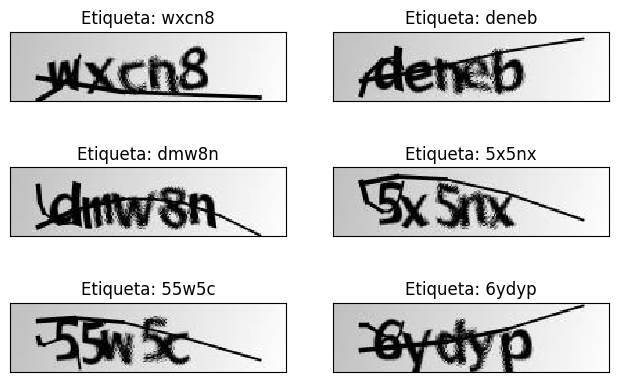

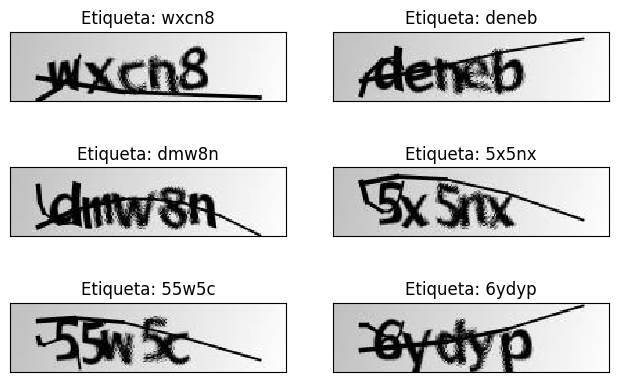

In [ ]:
# Se cargan los datos y se muestran algunas imágenes
X, y, label = load_process()
fig = plt.figure()
for i in range(6):
  plt.subplot(3,2,i+1)
  plt.tight_layout()
  plt.imshow(X[i,:,:,0], cmap='gray', interpolation='none')
  plt.title("Etiqueta: {}".format(label[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
print(X.shape, y.shape)

(1070, 50, 200, 1) (1070, 5)


In [ ]:
# AQUI CONVERTIMIOS LAS ETIQUETAS, CONVERTIMOS LAS FILAS EN COLUMNAS PARA CON ELLO EXTRAER LAS 5 COLUMNAS, CADA UNA DE LAS CUALES
# REPRESENTA UN CARACTER PARA CON ELLO CONVERTIR EL PROBLEMA EN MULTIOUTPUT
columnas = y.T
columnas2 = columnas.copy()

In [ ]:
# AQUI CREAMOS UNA VARIABLE PARA CADA UNA DE LAS COLUMNAS Y AGREGAMOS UNA DIMENSION MÁS PARA CONVERTIR CADA ARRAY EN (n, 1) DIMENSIONES
columnas21 =  np.expand_dims(np.array(columnas2[0][:]), -1)
columnas22 = np.expand_dims(np.array(columnas2[1][:]), -1)
columnas23 = np.expand_dims(np.array(columnas2[2][:]), -1)
columnas24 = np.expand_dims(np.array(columnas2[3][:]), -1)
columnas25 = np.expand_dims(np.array(columnas2[4][:]), -1)

In [ ]:
# AQUI CONCATENAMOS CADA UNA DE LAS CLASES DIVIDIDAS
Y = np.concatenate((columnas21, columnas22, columnas23,columnas24,columnas25), axis=1)

In [ ]:
# Se definen los conjuntos de entrenamiento y prueba.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
h = X_train.shape[1]
w  = X_train.shape[2]
c = X_train.shape[3]
input_shape = (h, w, c)
print(input_shape) #tamaño de las imágenes

(50, 200, 1)


In [ ]:
# ESTA FUNCIÓN NOS PERMITE DEFINIR LA ARQUITECTURA Y CREAR EL MODELO DE RED NEURONAL
def createmodel():
    # se define una serie de capas convolucionales. Esta parte es igual al resto
    # de redes que se han usado
    img = layers.Input(shape=(input_shape))
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)

    flat = layers.Flatten()(mp3)

    outs = [] # En esta lista se guardan las tres salidas. Las tres salidas se
    # aimentan de la salida de la capa flat.

    # Cada salida puede configurarse con diferents tipos de capas, a modo de ejemplo,
    # acá se utilizan estrucutras idénticas.

    # Salida 1: Clasificación con 36 clases.
    den_1 = layers.Dense(64, activation='relu')(flat)
    drop_1 = layers.Dropout(0.5)(den_1)
    # Changed 'Softmax' to 'softmax'
    sal_1 = layers.Dense(36, activation='softmax')(drop_1)
    outs.append(sal_1) #se añade el resultado a la lista

    # Salida 2: Clasificación con 36 clases.
    den_2 = layers.Dense(64, activation='relu')(flat)
    drop_2 = layers.Dropout(0.5)(den_2)
    sal_2 = layers.Dense(36, activation='softmax')(drop_2)
    outs.append(sal_2) #se añade el resultado a la lista

    # Salida 3: Clasificación con 36 clases.
    den_3 = layers.Dense(64, activation='relu')(flat)
    drop_3 = layers.Dropout(0.5)(den_3)
    # Changed 'Softmax' to 'softmax'
    sal_3 = layers.Dense(36, activation='softmax')(drop_3)
    outs.append(sal_3) #se añade el resultado a la lista

    # Salida 4: Clasificación con 36 clases.
    den_4 = layers.Dense(64, activation='relu')(flat)
    drop_4 = layers.Dropout(0.5)(den_4)
    # Changed 'Softmax' to 'softmax'
    sal_4 = layers.Dense(36, activation='softmax')(drop_4)
    outs.append(sal_4) #se añade el resultado a la lista

    # Salida 5: Clasificación con 36 clases.
    den_5 = layers.Dense(64, activation='relu')(flat)
    drop_5 = layers.Dropout(0.5)(den_5)
    # Changed 'Softmax' to 'softmax'
    sal_5 = layers.Dense(36, activation='softmax')(drop_5)
    outs.append(sal_5) #se añade el resultado a la lista

    # Compile model and return it
    model = Model(img, outs) #create model
    Loss = ['sparse_categorical_crossentropy','sparse_categorical_crossentropy','sparse_categorical_crossentropy','sparse_categorical_crossentropy','sparse_categorical_crossentropy']
    model.compile(loss=Loss, optimizer='adam',metrics=[['accuracy'], ['accuracy'], ['accuracy'],['accuracy'],['accuracy']])
    return model

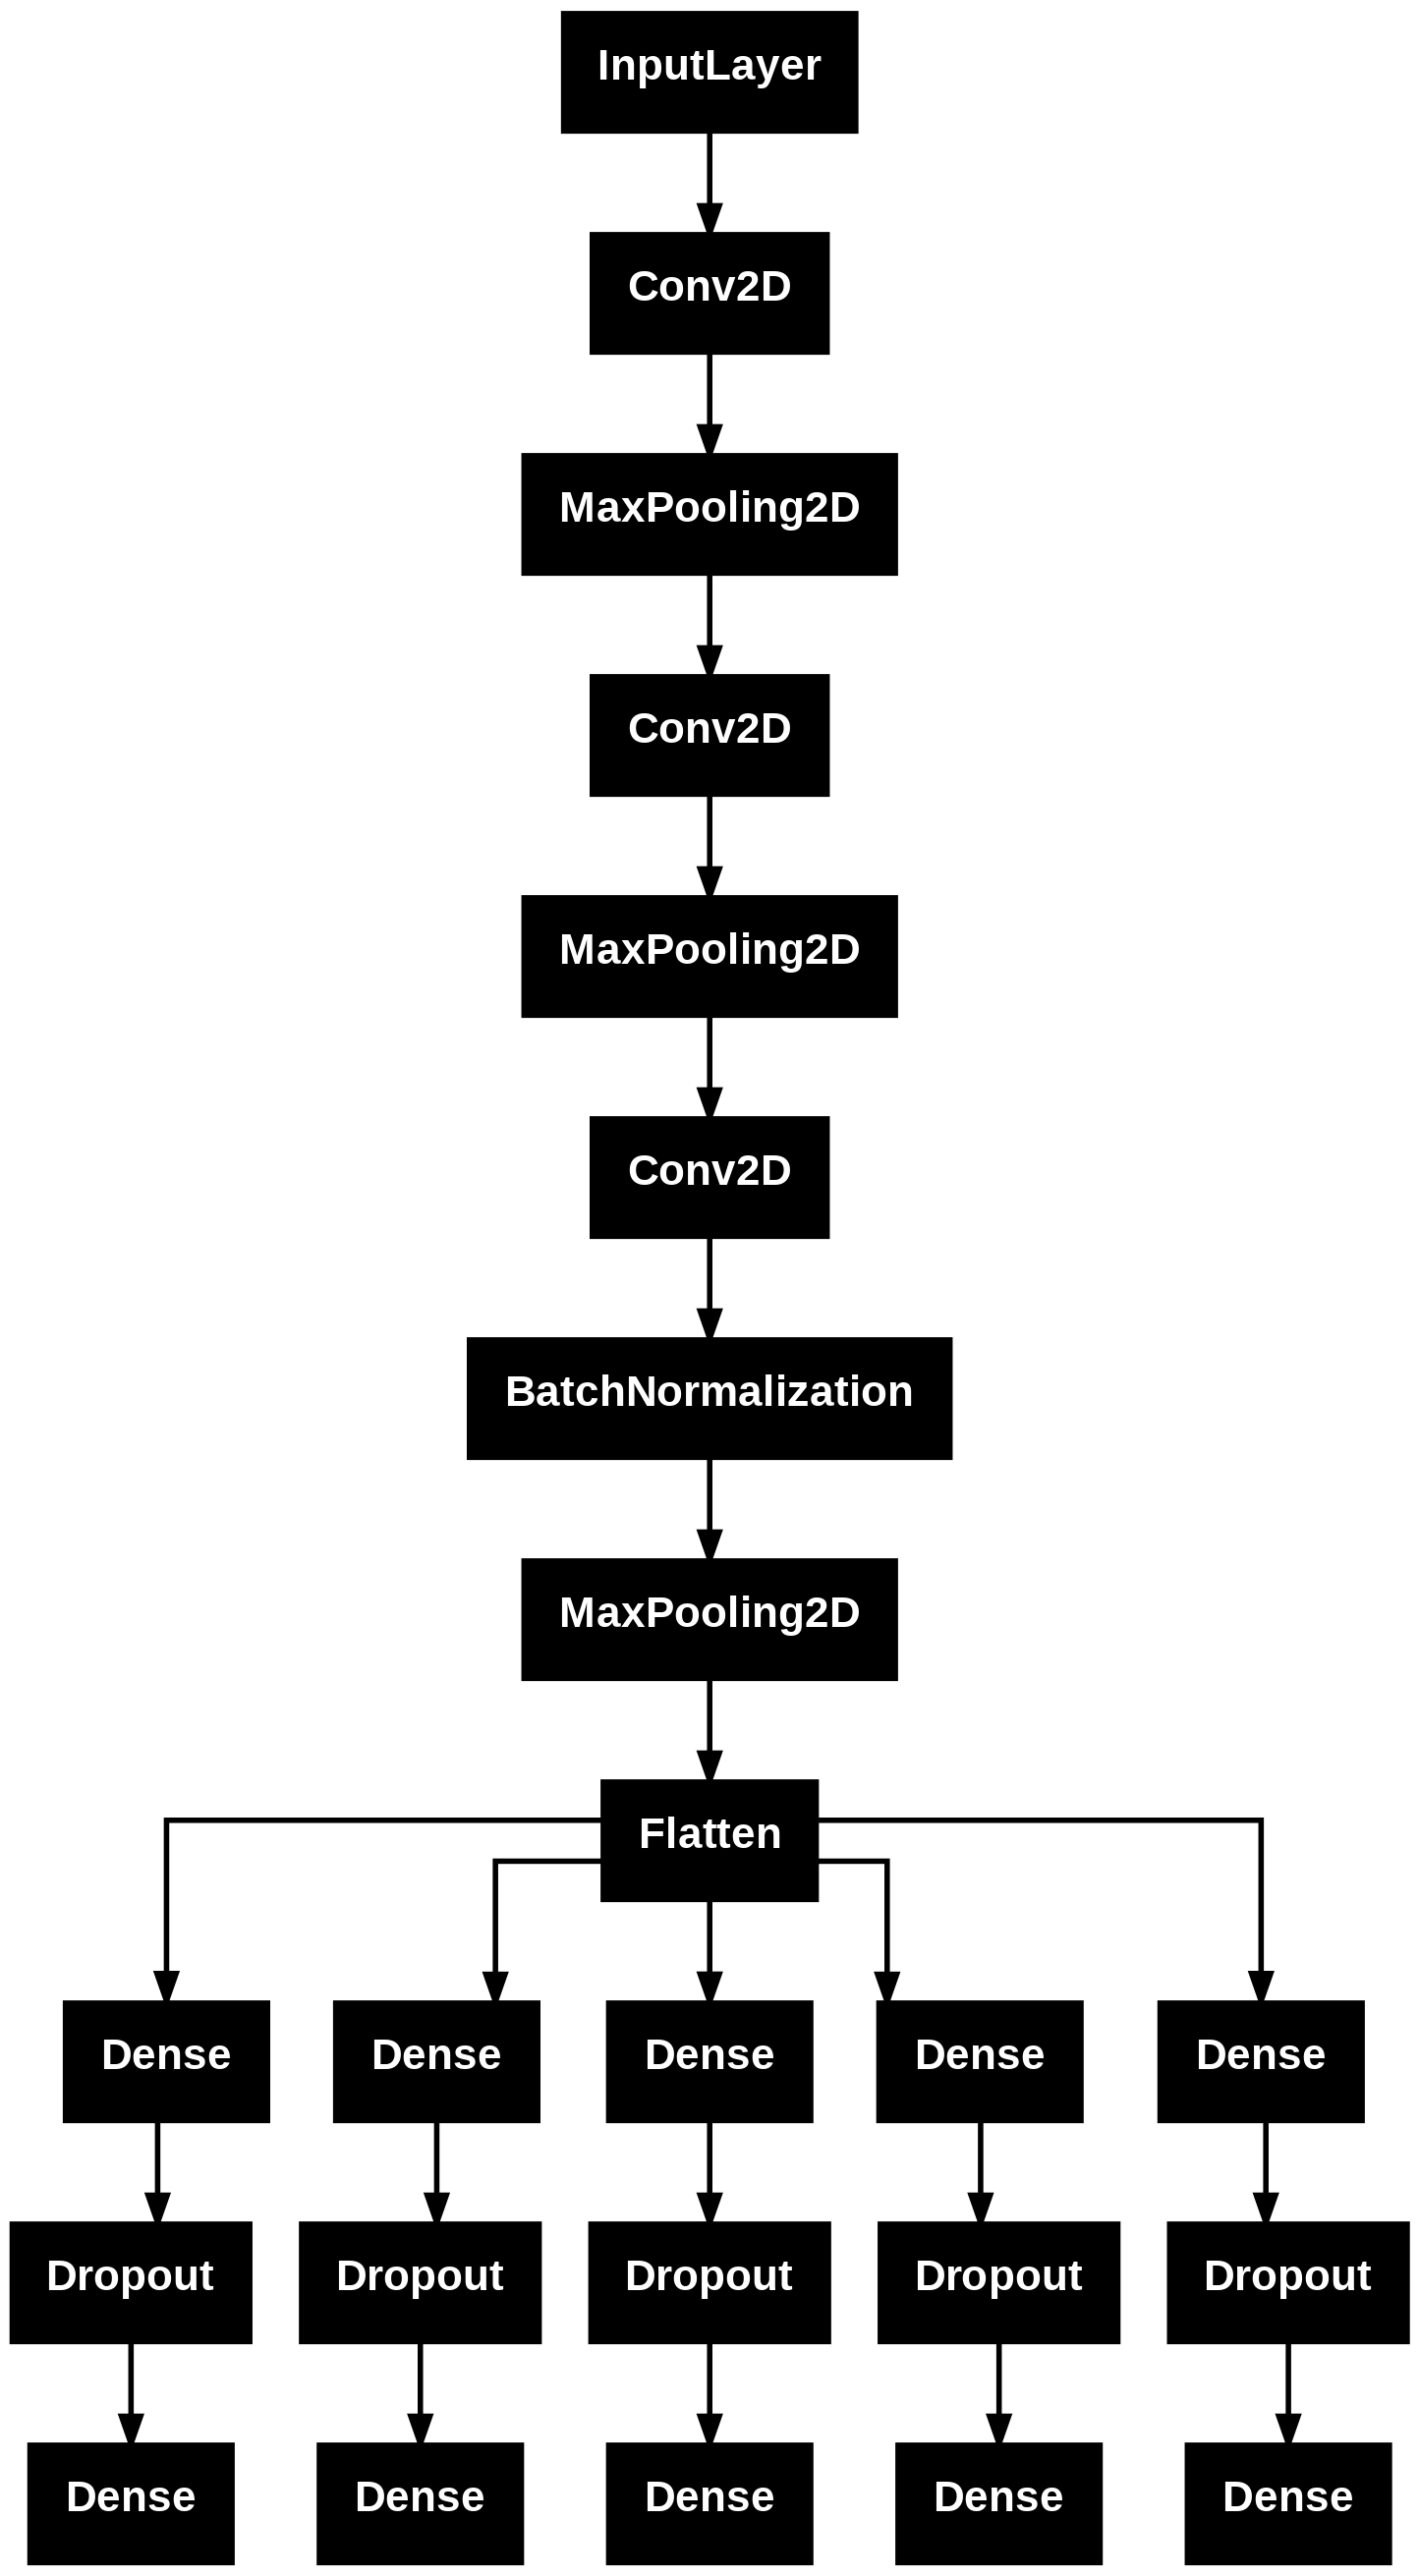

In [ ]:
# AQUÍ VISUALIZAMOS LA ARQUITECTURA DE LA RED NEURONAL
model = createmodel()
tf.keras.utils.plot_model(model)

In [ ]:
# AQUÍ ENTRENAMOS EL MODELO, COMO SE PUEDE VER SE AGREGAN LAS 5 ETIQUETAS PARA CADA CARACTER AL MOMENTO DE ENTRENAR Y EVALUAR EL MODELO
hist = model.fit(X_train, [ y_train[:,0],
                           y_train[:,1],
                           y_train[:,2],
                           y_train[:,3],
                           y_train[:,4]]
                           , batch_size=32, epochs=30,
                           validation_data=(X_test, [y_test[:,0],
                                                     y_test[:,1],
                                                     y_test[:,2],
                                                     y_test[:,3],
                                                     y_test[:,4]]))

Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 325ms/step - dense_11_accuracy: 0.0367 - dense_11_loss: 3.6853 - dense_13_accuracy: 0.0472 - dense_13_loss: 3.6989 - dense_15_accuracy: 0.0468 - dense_15_loss: 3.8639 - dense_17_accuracy: 0.0408 - dense_17_loss: 3.7956 - dense_19_accuracy: 0.0747 - dense_19_loss: 3.8261 - loss: 18.8715 - val_dense_11_accuracy: 0.1059 - val_dense_11_loss: 3.5439 - val_dense_13_accuracy: 0.0935 - val_dense_13_loss: 3.5378 - val_dense_15_accuracy: 0.0685 - val_dense_15_loss: 3.5541 - val_dense_17_accuracy: 0.0405 - val_dense_17_loss: 3.5426 - val_dense_19_accuracy: 0.0530 - val_dense_19_loss: 3.5364 - val_loss: 17.7228
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - dense_11_accuracy: 0.0855 - dense_11_loss: 3.2799 - dense_13_accuracy: 0.0818 - dense_13_loss: 3.2924 - dense_15_accuracy: 0.0600 - dense_15_loss: 3.4528 - dense_17_accuracy: 0.0617 - dense_17_loss: 3.4584 - dense_19_accuracy: 0.0744 - dense_19_loss: 3.3182 - loss: 16.8027 - val_dense_11_accuracy

In [ ]:
# AQUÍ SE MUESTRAN LA PRECISION DEL MODELO PARA CADA UNA DE LAS 5 ETIQUETAS A PREDECIR
preds = model.evaluate(X_test,[y_test[:,0], y_test[:,1],y_test[:,2],y_test[:,3],y_test[:,4]])
print('Acc_1:', preds[1])
print('Acc_2:', preds[3])
print('Acc_3:', preds[5])
print('Acc_3:', preds[7])
print('Acc_3:', preds[9])

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - dense_11_accuracy: 0.9775 - dense_11_loss: 0.1747 - dense_13_accuracy: 0.9225 - dense_13_loss: 0.3786 - dense_15_accuracy: 0.8145 - dense_15_loss: 0.7564 - dense_17_accuracy: 0.8013 - dense_17_loss: 0.9577 - dense_19_accuracy: 0.8225 - dense_19_loss: 0.7093 - loss: 3.0104
Acc_1: 0.11393279582262039
Acc_2: 0.571166455745697
Acc_3: 0.5831282734870911
Acc_3: 0.9376947283744812
Acc_3: 0.7757009267807007


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


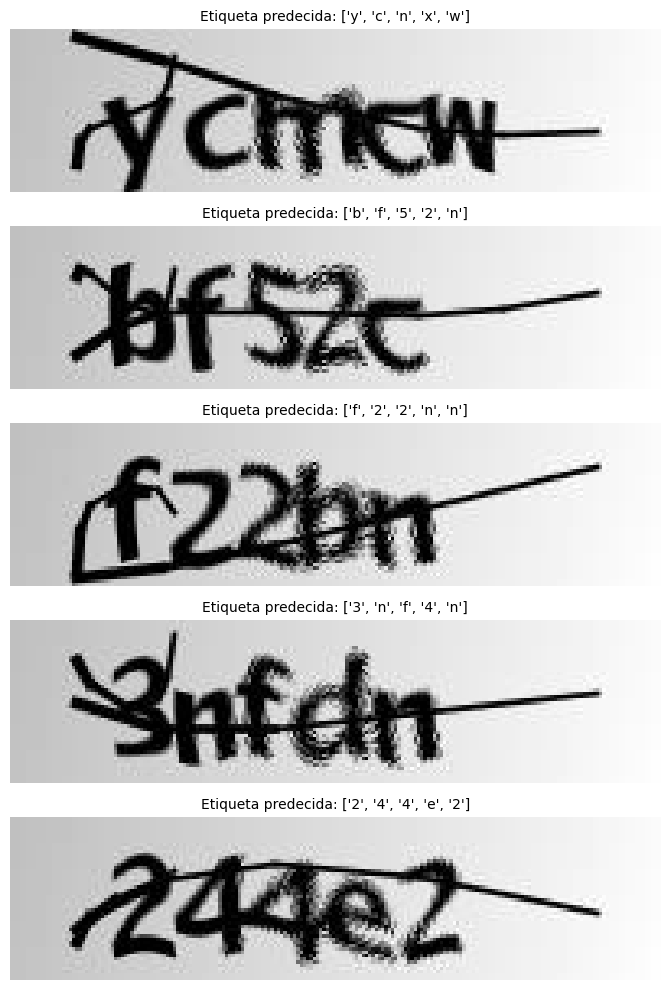

In [ ]:
# AQUI SE TOMAN AL AZAR 5 IMAGENES DEL DATASET DE PRUEBA Y SE REALIZAN LAS PREDICIONES USANDO EL MODELO ENTRENADO Y AL FINAL SE MUESTRA VISUAMENTE LOS RESULTADOS
random_numbers = np.random.randint(0, len(X_test), size=5)
predicciones = []
a = 0
text_predict2 = []
text_predict3 = []

plt.figure(figsize=(8, 10))

for i in random_numbers:
    # Redimensionar y preparar imagen
    img_final = np.expand_dims(np.expand_dims(cv2.resize(X_test[i], (200, 50)), -1), 0)

    # Predecir con el modelo
    prediction_1 = model.predict(img_final)
    text_index_predict = [np.argmax(arr) for arr in prediction_1]

    # Convertir índices a caracteres
    for j in text_index_predict:
        text_predict2.append(character[j])

    text_predict3.append(text_predict2)

    # Mostrar imagen con título ajustado
    plt.subplot(5, 1, a + 1)
    plt.imshow(X_test[i], cmap='gray', interpolation='none')
    plt.title("Etiqueta predecida: {}".format(text_predict3[a]), fontsize=10)
    plt.axis('off')

    a += 1
    text_predict2 = []

plt.tight_layout()
plt.show()
